# Assignment: NLP Sentiment Analysis

## 1. Introduction

Natural Language Processing (NLP) is presently among the hottest scientific fields with an enormous growth rate of the relevant research. Sentiment analysis is a popular NLP problem that aims at the automatic identification of the polarity in user reviews, tweets, blog posts, comments, forum discussions and so on.

In the vast majority of cases, sentiment analysis is treated as a text classification problem. If the involved text polarity is binary (i.e., positive or
negative, good or bad), then binary text classification models are trained by
utilizing two class labels. On the other hand, in case the polarity falls into a
closed score range (e.g., 1–5, 1–10, etc.), then each individual score is treated
as a separate class label and multi-class classification approaches are applied.

In this assignment you will explore various classifiers on NLP sentiment analysis. The purpose is to measure their performance on a dataset that derives from X (formerly Twitter) and contains user opinions about a US Airliner.


### Classifiers
The classifiers to be studied are:
* $C_1$: Logistic Regression
* $C_2$: Support Vector Machines (Linear kernel) - hint: use [`LinearSVC`](https://scikit-learn.org/dev/modules/generated/sklearn.svm.LinearSVC.html)
* $C_3$: Random Forests
* $C_4$: Feed-forward Neural Network


### Dataset

The classification performance of the abovementioned models will be studied on the `Twitter_US_Airline_Sentiment.csv` dataset ([see more details here](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)).

**The dataset is provided with the assignment in the present compressed file.**



## 2. Experiments

You will vectorize the text (located in the column `text`) by using the well-known TF-IDF technique. There will be three cases where the vocabulary of `TfidfVectorizer` will be limited to:

1. Contain words that appear in at least 5 documents (hint: `min_df` parameter of `TfidfVectorizer`).
2. Contain 2500 words (hint: `max_features` parameter of `TfidfVectorizer`).
3. Contain 500 words (hint: `max_features` parameter of `TfidfVectorizer`).

The classifiers will be evaluated by using 5-fold cross validation. Make sure that no information will be leaked from the training set to the test set. The values of the four following metrics will be measured:

* $M_1$: Accuracy
* $M_2$: F1-score
* $M_3$: Fit time


## Solution

### 1. Import Libraries

In [5]:
# Import all the necessary libraries for the project
import os
import pandas as pd
import numpy as np
import time
import re
import nltk
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import make_scorer, accuracy_score, f1_score

### 2. Load Dataset

In [7]:
# Load the twitter database from destination path
data = pd.read_csv(r"/Users/dimzografos/Desktop/Assignments/MLPC/Twitter_US_Airline_Sentiment.csv")

print("Dataframe shape:", data.shape)

# Display the first 10 rows of the dataframe
data.head(10)

Dataframe shape: (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [8]:
# Total of missing values
print(f"Missing values:\n", data.isnull().sum())

Missing values:
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [9]:
# Drop all except relevant features
data.drop(columns=[col for col in data.columns if col not in ["text", "airline_sentiment"]], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


### 3. Text Preprocessing

In [11]:
# Download required NLTK data (run once if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dimzografos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dimzografos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dimzografos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
# Define preprocessing function
def preprocessor(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    tokens = word_tokenize(text)  # Tokenize
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    return ' '.join(tokens)

In [13]:
# Apply preprocessing to all text data
data['text'] = data['text'].apply(preprocessor)

In [14]:
# Encode airline_sentiment column
le = LabelEncoder()
data['airline_sentiment'] = le.fit_transform(data['airline_sentiment'])

data[['text', 'airline_sentiment']].head()

,text,airline_sentiment
0,said,1
1,plus youve added commercial experience tacky,2
2,didnt today must mean need take another trip,1
3,really aggressive blast obnoxious entertainmen...,0
4,really big bad thing,0


In [15]:
# Split into features and target
X = data['text']
y = data['airline_sentiment']

### 4. Define Classifiers

In [17]:
# Define the classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
    'SVM': LinearSVC(multi_class='ovr', max_iter=1000, random_state=42, dual = True),
    'Random Forest': RandomForestClassifier(n_estimators=1000, random_state=42),
    'Feed-forward Neural Network': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=300, random_state=42)
}

### 5. Define TD-IDF Vectorization Settings

In [19]:
# Define the three TF-IDF vectorization settings
tfidf = {
    'min_df=5': TfidfVectorizer(min_df=5),
    'max_features=2500': TfidfVectorizer(max_features=2500),
    'max_features=500': TfidfVectorizer(max_features=500)
}

### 6. Create Pipeline and Evaluation Function

In [21]:
# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
# Create pipeline for each classifier
def create_pipeline(classifier, tfidf_vectorizer):
    return Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('classifier', classifier)
    ])

In [23]:
# Evaluate pipeline using cross-validation
def evaluate_pipeline(pipeline, X, y, kf, scoring):
    
    cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring, return_train_score=False)
    
    return {
        'Accuracy': np.mean(cv_results['test_accuracy']),
        'F1-score': np.mean(cv_results['test_f1_weighted']),
        'Fit Time (s)': np.mean(cv_results['fit_time'])
    }

### 7. Evaluate all Classifiers and IF-IDF Settings

In [25]:
# Function to evaluate all classifiers for each TF-IDF 
def evaluate_all_classifiers(X, y, tfidf, classifiers, kf):
    
    all_results = {}
    
    scoring = {'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted'}
    
    for setting_name, tfidf_vectorizer in tfidf.items():
        print(f"\nTF-IDF: {setting_name} \n")
        
        results = {}
        for name, clf in classifiers.items():
            pipeline = create_pipeline(clf, tfidf_vectorizer)
            metrics = evaluate_pipeline(pipeline, X, y, kf, scoring)
            results[name] = metrics
            
            print(f"{name}:")
            print(f"Accuracy: {metrics['Accuracy']*100:.2f} %")
            print(f"F1-score: {metrics['F1-score']*100:.2f} %")
            print(f"Fit Time: {metrics['Fit Time (s)']:.2f} seconds")
            print()
        
        all_results[setting_name] = results
    return all_results

### 8. Plotting Results

In [27]:
def plot_results(all_results):
    
    tfidf_names = list(all_results.keys())
    classifier_names = list(classifiers.keys())
    
    # Prepare data for plotting
    accuracy_data = {clf: [] for clf in classifier_names}
    f1_data = {clf: [] for clf in classifier_names}
    for setting in tfidf_names:
        for clf in classifier_names:
            accuracy_data[clf].append(all_results[setting][clf]['Accuracy'])
            f1_data[clf].append(all_results[setting][clf]['F1-score'])
    
    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    for clf in classifier_names:
        plt.plot(tfidf_names, accuracy_data[clf], marker='o', label=clf)
    plt.title('Classifier Accuracy Across TF-IDF Settings')
    plt.xlabel('TF-IDF Setting')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot F1-score
    plt.figure(figsize=(12, 6))
    for clf in classifier_names:
        plt.plot(tfidf_names, f1_data[clf], marker='o', label=clf)
    plt.title('Classifier F1-Score Across TF-IDF Settings')
    plt.xlabel('TF-IDF Setting')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)
    plt.show()

### 9. Run Experiments and Save Results

In [29]:
# Run Evaluation
all_results = evaluate_all_classifiers(X, y, tfidf, classifiers, kf)


TF-IDF: min_df=5 

Logistic Regression:
Accuracy: 77.78 %
F1-score: 76.61 %
Fit Time: 0.11 seconds

SVM:
Accuracy: 77.56 %
F1-score: 76.92 %
Fit Time: 0.07 seconds

Random Forest:
Accuracy: 76.24 %
F1-score: 74.98 %
Fit Time: 22.30 seconds

Feed-forward Neural Network:
Accuracy: 73.63 %
F1-score: 73.71 %
Fit Time: 18.35 seconds


TF-IDF: max_features=2500 

Logistic Regression:
Accuracy: 77.94 %
F1-score: 76.78 %
Fit Time: 0.14 seconds

SVM:
Accuracy: 77.53 %
F1-score: 76.90 %
Fit Time: 0.07 seconds

Random Forest:
Accuracy: 76.30 %
F1-score: 75.03 %
Fit Time: 22.74 seconds

Feed-forward Neural Network:
Accuracy: 73.18 %
F1-score: 73.28 %
Fit Time: 19.67 seconds


TF-IDF: max_features=500 

Logistic Regression:
Accuracy: 76.13 %
F1-score: 75.08 %
Fit Time: 0.10 seconds

SVM:
Accuracy: 76.56 %
F1-score: 75.71 %
Fit Time: 0.08 seconds

Random Forest:
Accuracy: 75.16 %
F1-score: 73.95 %
Fit Time: 18.55 seconds

Feed-forward Neural Network:
Accuracy: 73.94 %
F1-score: 73.62 %
Fit Time: 11

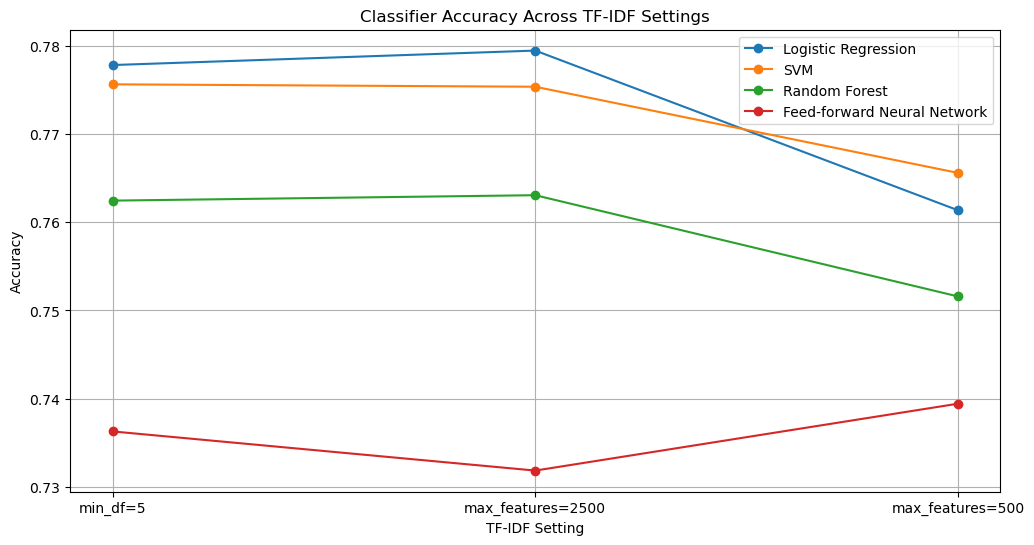

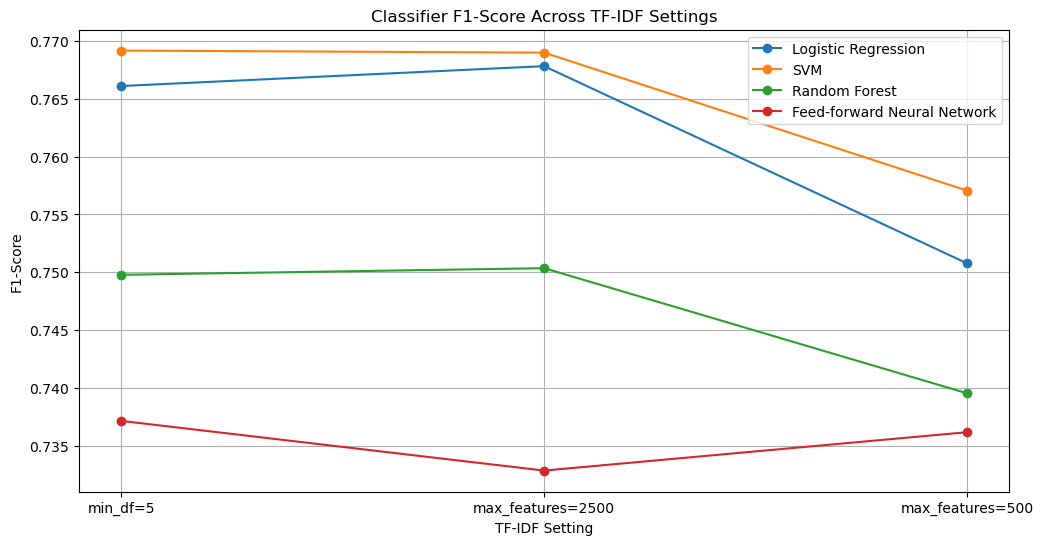

In [30]:
# Run the Plots
plot_results(all_results)

In [31]:
file_name = "sentiment_analysis_no_tuning.csv"
folder_path = r"/Users/dimzografos/Desktop/Assignments/MLPC"
full_path = os.path.join(folder_path, file_name)

os.makedirs(folder_path, exist_ok=True)

# Save as CSV
data.to_csv(full_path, index=False)

print(f"File saved at: {full_path}")

File saved at: /Users/dimzografos/Desktop/Assignments/MLPC/sentiment_analysis_no_tuning.csv
